In [1]:
# load in the structures destroyed (in California?)
# Load in all of the structures destroyed

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from ocr import catalog

In [3]:
catalog

                                        📊 OCR Dataset Catalog (8 datasets)                                        
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Name                 ┃ Description                 ┃ Format ┃ Version       ┃ Storage Location                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 2011-climate-run     │ USFS 2011 Climate Run       │ zarr   │ v1            │ s3://carbonplan-ocr/input/fire-ri │
│                      │                             │        │               │ sk/tensor/USFS/2011ClimateRun_Ice │
│                      │                             │        │               │ chunk                             │
├──────────────────────┼─────────────────────────────┼────────┼───────────────┼───────────────────────────────────┤
│ 2047-climate-run     │ USFS 2047 Climate Run       │ zarr   │ v1            │ s3://carbonplan-ocr/input/fire-ri │
│                      │                             │        │               │ sk/tensor/USFS/2047ClimateRun_Ice │
│                      │                             │        │               │ chunk                             │
├──────────────────────┼─────────────────────────────┼────────┼───────────────┼───────────────────────────────────┤
│ alexandre-2016-digit │ Data from: Factors related  │ geopar │ v1            │ s3://carbonplan-ocr/input/fire-ri │
│ ized-buildings       │ to building loss due to     │ quet   │               │ sk/vector/alexandre-2016/digitize │
│                      │ wildfires in the            │        │               │ d_buildings_2000_2010.parquet     │
│                      │ conterminous United States  │        │               │                                   │
├──────────────────────┼─────────────────────────────┼────────┼───────────────┼───────────────────────────────────┤
│ cal-fire-damage-insp │ CAL FIRE Damage Inspection  │ geopar │ v1            │ s3://carbonplan-ocr/input/fire-ri │
│ ection               │ (DINS) dataset              │ quet   │               │ sk/vector/cal-fire-structures-des │
│                      │                             │        │               │ troyed/cal-fire-structures-destro │
│                      │                             │        │               │ yed.parquet                       │
├──────────────────────┼─────────────────────────────┼────────┼───────────────┼───────────────────────────────────┤
│ conus-overture-addre │ CONUS Overture Addresses    │ geopar │ v2025-03-19.1 │ s3://carbonplan-ocr/input/fire-ri │
│ sses                 │                             │ quet   │               │ sk/vector/CONUS_overture_addresse │
│                      │                             │        │               │ s_2025-03-19.1.parquet            │
├──────────────────────┼─────────────────────────────┼────────┼───────────────┼───────────────────────────────────┤
│ conus-overture-build │ CONUS Overture Buildings    │ geopar │ v2025-03-19.1 │ s3://carbonplan-ocr/input/fire-ri │
│ ings                 │                             │ quet   │               │ sk/vector/CONUS_overture_building │
│                      │                             │        │               │ s_2025-03-19.1.parquet            │
├──────────────────────┼─────────────────────────────┼────────┼───────────────┼───────────────────────────────────┤
│ era5-fire-weather-da │ ERA5 Fire Weather Days      │ zarr   │ v2            │ s3://carbonplan-risks/era5/fire_w │
│ ys                   │                             │        │               │ eather_days_v2.zarr               │
├──────────────────────┼─────────────────────────────┼────────┼───────────────┼───────────────────────────────────┤
│ wildfire-communities │ Wildfire Communities        │ zarr   │ v1            │ s3://carbonplan-risks/wildfirecom │
│                      │ Dataset                     │   

In [4]:
# load in structures destroyed Alexandre 2016 https://esajournals.onlinelibrary.wiley.com/doi/10.1002/eap.1376
gdf = catalog.get_dataset('alexandre-2016-digitized-buildings', version='v1').to_geopandas(
    """SELECT cluster_id, year, type_b, X, Y, fire_id, state, ST_AsText(geometry) as geometry FROM read_parquet('{s3_path}')""",
    crs='EPSG:5070',
)
gdf.head()

,cluster_id,year,type_b,X,Y,fire_id,state,geometry
0,20000,2000,UB,1565532.548,430088.4530,FL-110-20000409,FL,POINT (1565532.548 430088.453)
1,20000,2000,UB,1565471.618,430096.1449,FL-110-20000409,FL,POINT (1565471.618 430096.145)
2,20000,2000,UB,1565329.907,430170.0066,FL-110-20000409,FL,POINT (1565329.907 430170.007)
3,20000,2000,UB,1565402.075,430142.8598,FL-110-20000409,FL,POINT (1565402.075 430142.86)
4,20000,2000,UB,1565443.291,430131.2027,FL-110-20000409,FL,POINT (1565443.291 430131.203)


In [5]:
riley = {}
riley['2011'] = catalog.get_dataset('2011-climate-run', version='v1').to_xarray(is_icechunk=True)
riley['2047'] = catalog.get_dataset('2047-climate-run', version='v1').to_xarray(is_icechunk=True)

In [6]:
lat_min, lat_max = 33.5, 34.5
lon_min, lon_max = -117.6, -116
xy = gpd.points_from_xy([lon_min, lon_max], [lat_min, lat_max], crs='EPSG:4326')
xy = xy.to_crs('EPSG:5070')
x_min, x_max = xy.x.min(), xy.x.max()
y_min, y_max = xy.y.min(), xy.y.max()

In [7]:
subset = gdf.cx[x_min:x_max, y_min:y_max]
subset = subset[subset['year'] == 2003]

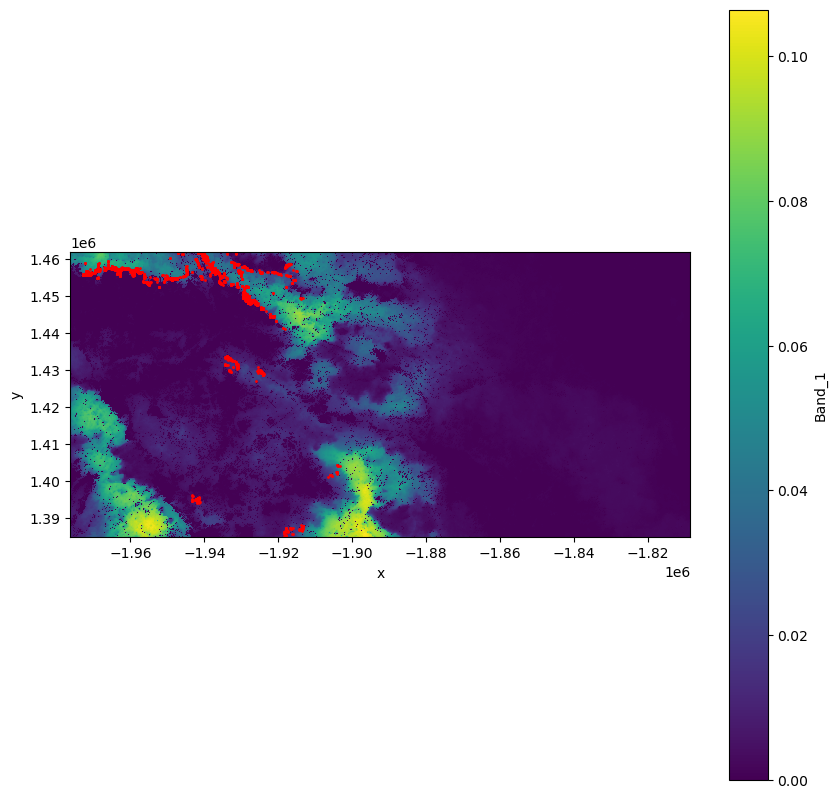

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
riley['2011'].sel(x=slice(x_min, x_max), y=slice(y_max, y_min)).BP.plot(ax=ax)
subset.plot(ax=ax, color='red', markersize=1)
# plt.title("Burned Structures Located in box in Northern California")
plt.show()

In [9]:
eaton = catalog.get_dataset('cal-fire-damage-inspection', version='v1').to_geopandas(
    """SELECT INCIDENTNAME, DAMAGE	, Latitude, Longitude, SITEADDRESS, ST_AsText(geometry) as geometry, FROM read_parquet('{s3_path}') WHERE INCIDENTNAME='Eaton' """
)
eaton

,INCIDENTNAME,DAMAGE,Latitude,Longitude,SITEADDRESS,geometry
0,Eaton,No Damage,34.183522,-118.102419,"2190 GRAND OAKS AVE, ALTADENA, CA 91001",POINT (-118.10242 34.18352)
1,Eaton,Destroyed (>50%),34.196158,-118.158133,"512 DEVIRIAN PL, ALTADENA, CA 91001",POINT (-118.15813 34.19616)
2,Eaton,No Damage,34.183466,-118.100784,"2211 N ALTADENA DR, ALTADENA, CA 91001",POINT (-118.10078 34.18347)
3,Eaton,No Damage,34.178690,-118.099171,"1900 N ALTADENA DR, PASADENA, CA 91107",POINT (-118.09917 34.17869)
4,Eaton,No Damage,34.187668,-118.110852,"1918 BRAEBURN RD, ALTADENA, CA 91001",POINT (-118.11085 34.18767)
...,...,...,...,...,...,...
18417,Eaton,Inaccessible,34.179875,-118.098786,"1955 CANYON CLOSE RD, PASADENA, CA 91107",POINT (-118.09879 34.17988)
18418,Eaton,No Damage,34.165192,-118.095695,"1102 BELLA VISTA AVE, PASADENA, CA 91107",POINT (-118.09569 34.16519)
18419,Eaton,No Damage,34.176275,-118.137805,"1773 N EL MOLINO AVE, PASADENA, CA 91104",POINT (-118.1378 34.17628)
18420,Eaton,No Damage,34.163741,-118.094821,"1016 N VINEDO AVE, PASADENA, CA 91107",POINT (-118.09482 34.16374)


In [10]:
x_min, x_max = eaton.geometry.x.min(), eaton.geometry.x.max()
y_min, y_max = eaton.geometry.y.min(), eaton.geometry.y.max()

In [12]:
slice(x_min, x_max)

slice(-118.16359507363843, -118.01833468855428, None)

In [13]:
riley['2011'].sel(x=slice(x_min, x_max), y=slice(y_max, y_min)).BP.plot(ax=ax)

TypeError: No numeric data to plot.

In [16]:
important_days = catalog.get_dataset('era5-fire-weather-days', version='v2').to_xarray(
    is_icechunk=False, xarray_open_kwargs={'engine': 'zarr'}
)

In [17]:
important_days.sel(latitude=34.17, longitude=-118.09, method='nearest')

<xarray.Dataset> Size: 4MB
Dimensions:                                       (time: 262968)
Coordinates:
    latitude                                      float32 4B 34.25
    longitude                                     float32 4B 235.0
  * time                                          (time) datetime64[ns] 2MB 1...
Data variables:
    10m_wind_gust_since_previous_post_processing  (time) float32 1MB ...
    sfcWindfromdir                                (time) float32 1MB ...

In [18]:
def plot_windrose(winddir, windspeeds, bins=np.arange(0, 20, 1), title='Wind gusts (m/s)'):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'windrose'})
    ax.bar(
        winddir.values, windspeeds.values, bins=bins, normed=True, opening=0.8, edgecolor='white'
    )

    # Customize the plot
    ax.set_legend(title=title)

    return fig, ax

In [19]:
def lon_to_180(ds):
    lon = ds['longitude'].where(ds['longitude'] < 180, ds['longitude'] - 360)
    ds = ds.assign_coords(longitude=lon)
    return ds

Text(0.5, 0.98, '34.17, -118.09')

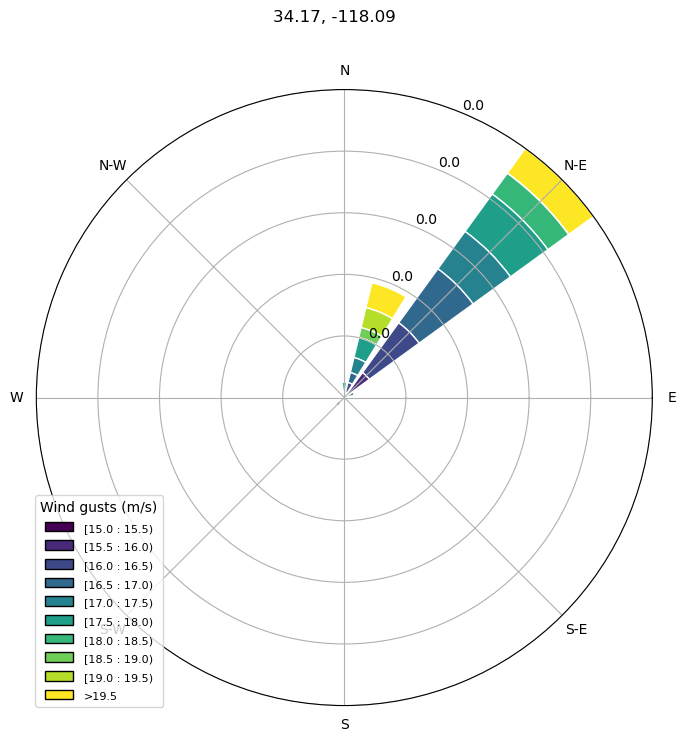

In [20]:
lat = 34.17
lon = -118.09
important_days_to_plot = (
    lon_to_180(important_days).sel(latitude=lat, longitude=lon, method='nearest').compute()
)
fig, ax = plot_windrose(
    important_days_to_plot['sfcWindfromdir'],
    important_days_to_plot['10m_wind_gust_since_previous_post_processing'],
    bins=np.arange(15, 20, 0.5),
)
fig.suptitle(f'{lat}, {lon}')

TypeError: No numeric data to plot.

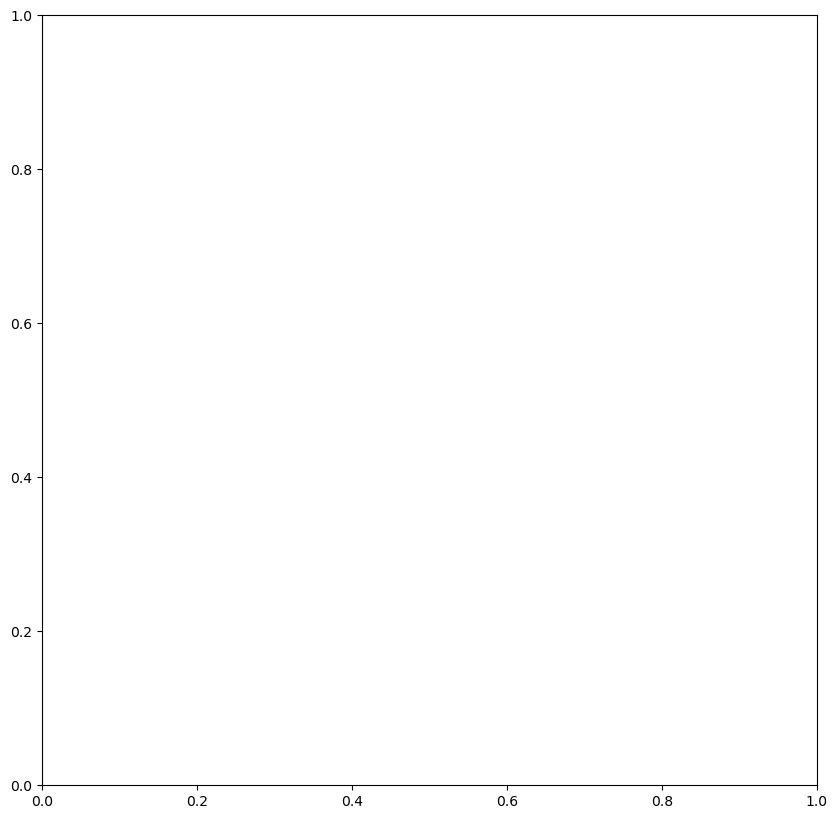

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
riley['2011'].sel(
    x=slice(x_min, x_max),
    y=slice(y_max, y_min),
).BP.plot(ax=ax)
eaton.plot(ax=ax, color='red', markersize=1)
plt.title('Eaton fire 2025')

In [23]:
# Step 5: Load California boundary (state outline) using Geopandas' built-in datasets
california = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# california = california[california.name == 'California']

# # Step 6: Filter out points within California's boundaries
# gdf_ca = gdf[gdf.geometry.within(california.geometry.iloc[0])]

AttributeError: The geopandas.dataset has been deprecated and was removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.